In [1]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys


[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
import preprocess
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *
import model_utils


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import FactorAnalysis, PCA


data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'
participant = 'T5/historical/'
min_nblocks = 3

# preprocess by selecting sessions with a minimal block count:
files       = loadDataset(data_dir, participant)
files       = get_Sessions(files, min_nblocks, manually_remove = None)

### train RNN on day 0, get baseline performance measure


In [2]:
import torch
import models

def convert_to_seqs(data, seqlen):
    '''Chop up array into smaller arrays of length <seqlen>'''
    nSeqs = int(data.shape[0] / seqlen)
    seqs  = np.array_split(data, nSeqs, axis = 0)
    
    return seqs


def prepareSessionForRNN(file, cfg):
    '''Prep session data for RNN'''
    
    session       = DataStruct(file, alignScreens = True, causal_filter = cfg['sigma'])

    train_x, test_x, train_y, test_y, train_cursor, _   = getTrainTest(session, train_size = cfg['train_size'], task = cfg['task'], 
                                                                      blocks = cfg['blocks'], returnFlattened = True, returnCursor = True)
    
    train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y          = np.concatenate(train_y)
    test_y           = np.concatenate(test_y)
    train_cursor     = np.concatenate(train_cursor)

    # standardize velocities to be in [-1, 1]
    ymax     = max(np.max(train_y), np.max(test_y))
    train_y /= ymax
    test_y  /= ymax

    # normalize input features
    thresh   = np.percentile(train_x, 99) * 2 
    test_x[np.abs(test_x) > thresh] = thresh * np.sign(test_x[np.abs(test_x) > thresh])

    input_sd = np.std(train_x, axis = 0)
    train_x[:, input_sd != 0] /= input_sd[None, input_sd != 0]
    test_x[:, input_sd != 0]  /= input_sd[None, input_sd != 0]

    # generate sequences to support minibatch training 
    if cfg['seqlen'] > 0:
        x_train      = convert_to_seqs(train_x, seqlen = cfg['seqlen'])
        y_train      = convert_to_seqs(train_y, seqlen = cfg['seqlen'])
        cursor_train = convert_to_seqs(train_cursor, seqlen = cfg['seqlen'])
    else:
        x_train = [train_x]
        y_train = [train_y]
        cursor_train = [train_cursor]
    
    x_val    = [test_x]
    y_val    = [test_y] 
    
    return x_train, y_train, x_val, y_val, cursor_train
    
    
def addRandomWalk(timeseries, strength):
    '''Apply mean drift to timeseries data using autoregressive noise'''
    nSamples, nChannels = timeseries.shape
    noise               = np.zeros(timeseries.shape)
    noise[0, :]         = np.random.normal(0, strength, size = nChannels)
    for t in range(1, nSamples):
        noise[t, :] = noise[t-1, :] + np.random.normal(0, strength, size = nChannels)  
        
    return timeseries + noise

def addWhiteNoise(timeseries, strength):
    noise = np.random.normal(0, strength, size = timeseries.shape)    
    return timeseries + noise

def addOffset(timeseries, strength):
    offset      = np.random.normal(0, strength, size = timeseries.shape[1])  
    return timeseries + offset

def addNoise(timeseries, offset_strength = 0, whitenoise_strength = 0, randomwalk_strength = 0):   
    if offset_strength > 0:
        timeseries = addOffset(timeseries, strength = offset_strength)
    if whitenoise_strength > 0:
        timeseries = addWhiteNoise(timeseries, strength = offset_strength)
    if randomwalk_strength > 0:
        timeseries = addRandomWalk(timeseries, strength = randomwalk_strength) 
        
    return timeseries

In [5]:

n_epochs    = 100
print_every = 5
batch_size  = 50

offset_strength     = 0.3
whitenoise_strength = 0.1
randomwalk_strength = 0.02

loss_curves = [[], []]

for epoch in range(1, n_epochs + 1):
    x_train_perturbed = [addNoise(x, offset_strength, whitenoise_strength, randomwalk_strength) for x in x_train]
    model_utils.trainRNN(model, loss_fcn, optimizer, x_train_perturbed, y_train, batch_size = batch_size, ignore_index = 0, shuffle = True, DEVICE = DEVICE, addNoise = 0.)
    if epoch % print_every == 0:
        train_loss, train_corr = model_utils.evaluateRNN(model, loss_fcn, x_train, y_train, batch_size, DEVICE = DEVICE)
        val_loss, val_corr     = model_utils.evaluateRNN(model, loss_fcn, x_val, y_val, batch_size, DEVICE = DEVICE)

        loss_curves[0].append(train_loss)
        loss_curves[1].append(val_loss)
        print('----------Epoch ', epoch, ' -------------')
        print('Train loss: ', train_loss)
        print('Val loss: ', val_loss)

----------Epoch  5  -------------
Train loss:  0.04222838615763729
Val loss:  0.05213934321699623
----------Epoch  10  -------------
Train loss:  0.0329038512648694
Val loss:  0.04325222274364951
----------Epoch  15  -------------
Train loss:  0.030189611929404076
Val loss:  0.03948630314956714
----------Epoch  20  -------------
Train loss:  0.029695797455516836
Val loss:  0.03797136218824461
----------Epoch  25  -------------
Train loss:  0.027366912575470467
Val loss:  0.03604476006254581
----------Epoch  30  -------------
Train loss:  0.026286349155155306
Val loss:  0.03479792588020025
----------Epoch  35  -------------
Train loss:  0.025545746832593152
Val loss:  0.034431808611736774
----------Epoch  40  -------------
Train loss:  0.024886200594483085
Val loss:  0.03378728216450558
----------Epoch  45  -------------
Train loss:  0.023987810561864477
Val loss:  0.03336294410271132
----------Epoch  50  -------------
Train loss:  0.023343512653247755
Val loss:  0.03270356364181013
---

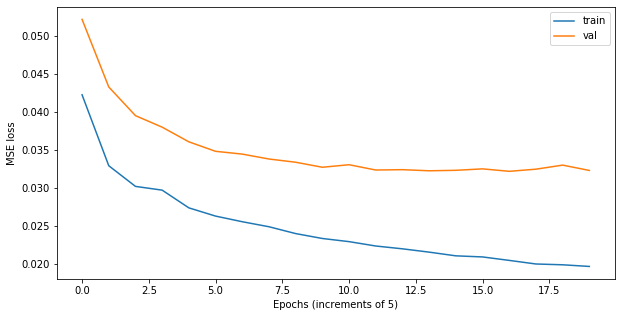

In [6]:
figSize(5, 10)

plt.figure()
for i, label in enumerate(['train', 'val']):
    plt.plot(loss_curves[i], label = label)

plt.legend()
plt.ylabel('MSE loss')
plt.xlabel('Epochs (increments of ' + str(print_every) + ')')
plt.show()

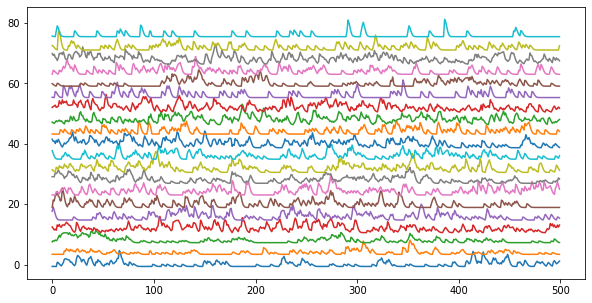

In [29]:
_ = plt.plot(x_val[0][:500, :20] + np.arange(20) * 4)
plt.savefig(fig_path + 'RNN/rnn_example_neural.pdf')
plt.show()

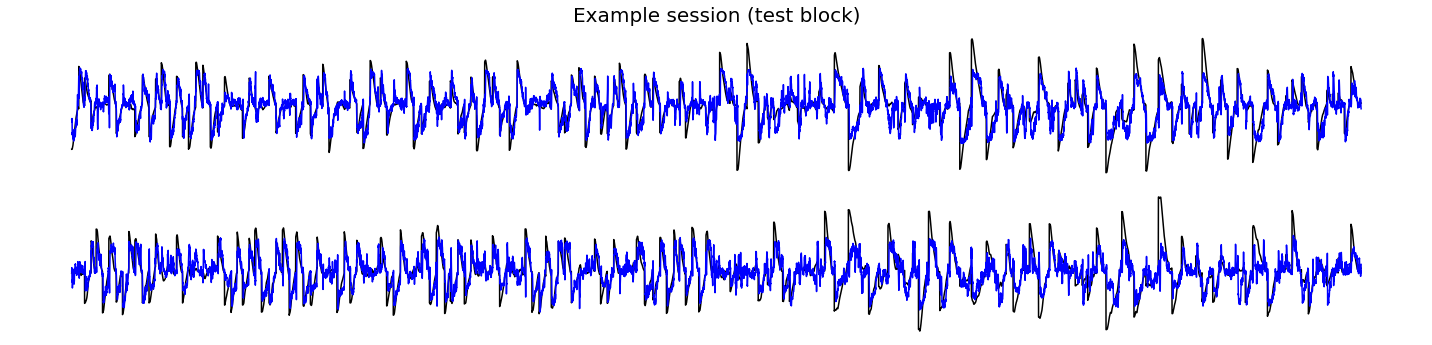

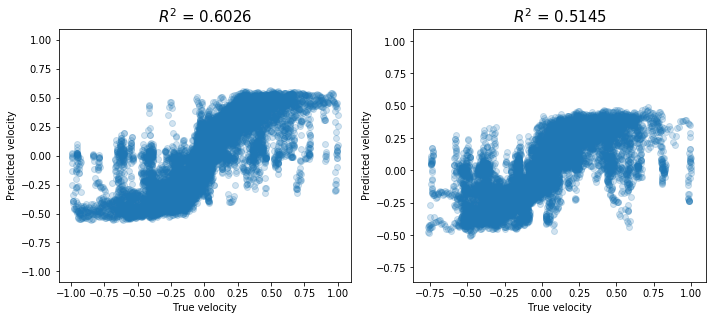

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

model.eval()
preds  = model_utils.predictRNN(model, x_val, y_val, DEVICE = DEVICE)

figSize(5, 20)

plt.figure(1)
trl = 0

for i in range(output_size):
    x = y_val[trl][:, i]
    y = preds[trl].squeeze()[:, i]
    
    plt.subplot(output_size, 1, i + 1)
    _ = plt.plot(x, color = 'k')
    plt.axis('off')
    _ = plt.plot(y, color = 'b')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.suptitle('Example session (test block)', fontsize = 20)

plt.savefig(fig_path + 'RNN/rnn_example.pdf')


figSize(5, 10)

plt.figure(2)
for i in range(output_size):
    x = y_val[trl][:, i]
    y = preds[trl].squeeze()[:, i]
    
    plt.subplot(1, 2,  i + 1)
    plt.scatter(x, y, alpha = 0.2)
    minval = min(x.min(), y.min()) - 0.1
    maxval = max(x.max(), y.max()) + 0.1
    plt.xlim([minval, maxval])
    plt.ylim([minval, maxval])
    plt.xlabel('True velocity')
    plt.ylabel('Predicted velocity')
    plt.title('$R^2$ = ' + str(np.round(r2_score(x, y), 4)), fontsize = 15)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])

#plt.savefig(fig_path + 'RNN/rnn_example.pdf')

plt.show()

### test RNNs on new sessions

In [ ]:
import hmm_utils

gridSize      = 20  
stayProb      = 0.999
vmKappa       = 4


#-----------------------------------------

adjustKappa             = lambda dist : 1 / (1 + np.exp(-1 * (dist - 70) * 0.5))
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize, stayProb)


model_files = glob.glob(data_dir + 'T5/RNNs/*')
model_dates = [x.split('RNNs/t5.')[1].split('_rnn')[0] for x in model_files]

scores_dict = {'reference' : list(), 'test' : list(), 'meanrecal' : list(), 'HMM' : list(), 'linear' : list()}

for i, file_A in enumerate(files):
    file_A_date = file_A.split('t5.')[1].split('.mat')[0]
    model_idx   = model_dates.index(file_A_date)
    model       = torch.load(model_files[model_idx])
    
    for j, file_B in enumerate(files):
        file_B_date = file_B.split('t5.')[1].split('.mat')[0]
        
        if j > i and preprocess.daysBetween(file_A_date, file_B_date) < 30:
            scores_dict['reference'].append(file_A)
            scores_dict['test'].append(file_B)
            
            # get model predictions
            cfg = dict()
            cfg['train_size'] = 0.67
            cfg['task']       = None
            cfg['blocks']     = None
            cfg['sigma']      = 2
            cfg['seqlen']     = -1   # dont chop up yet - need to run HMM over timeseries to infer labels

            x_train, y_train, x_val, y_val, cursorpos_train = prepareSessionForRNN(file_B, cfg)

            torch.cuda.empty_cache()
            DEVICE  = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
            model.to(DEVICE)
            preds   = model_utils.predictRNN(model, x_train, DEVICE = DEVICE)[0].squeeze()
            
            # Get mean recalibrated performance
            preds_val       = model_utils.predictRNN(model, x_val, DEVICE = DEVICE)[0].squeeze()
            score_meanrecal = r2_score(y_val[0], preds_val, multioutput = 'variance_weighted')
            scores_dict['meanrecal'].append(score_meanrecal)
            
            
            # Infer target labels
            new_dat     = DataStruct(file_A, alignScreens = True)
            targLocs    = get_DiscreteTargetGrid(new_dat, gridSize = gridSize, task = None)
            hmm         = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa)
            
            targ_states    = hmm.viterbi_search(preds, cursorpos_train[0])[0]
            inferred_targs = targLocs[targ_states.astype('int').flatten(), :] 
            pTargs         = hmm.decode(preds, cursorpos_train[0])[0]
            maxProb        = np.max(pTargs, axis = 0)       # get P(H_i | O_1, ...., O_n)
            maxProb        = np.vstack([maxProb, maxProb]).T
            
            y_train_hat  = inferred_targs - cursorpos_train[0]
            y_train_hat /= np.max(y_train_hat)
            
            # Recalibrate RNN using these inferred labels 
            n_epochs    = 100
            batch_size  = 50
            
            dropout             = 0.1
            offset_strength     = 0.3
            whitenoise_strength = 0.1
            randomwalk_strength = 0.02

            optimizer   = torch.optim.Adam(model.parameters(), lr= 0.008)
            DEVICE      = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
            model.to(DEVICE)
            
            x_train_seqs = convert_to_seqs(x_train[0],  seqlen = 900)
            y_train_seqs = convert_to_seqs(y_train_hat, seqlen = 900)
            w_train_seqs = convert_to_seqs(maxProb**2,  seqlen = 900)

            for epoch in range(n_epochs):
                x_train_perturbed = [addNoise(x, offset_strength, whitenoise_strength, randomwalk_strength) for x in x_train_seqs]
                model_utils.trainRNN(model, optimizer, x_train_perturbed, y_train_seqs, w_list = w_train_seqs, batch_size = batch_size, shuffle = True, DEVICE = DEVICE)
            
            # Evaluate performance 
            model.eval()
            preds              = model_utils.predictRNN(model, x_val, DEVICE = DEVICE)
            score_hmm          = r2_score(y_val[0], preds[0].squeeze(), multioutput = 'variance_weighted')
            scores_dict['HMM'].append(score_hmm)
            

            # get linear regression score: 
            ref_decoder              = LinearRegression(normalize = False).fit(np.concatenate(x_train), np.concatenate(y_train))
            scores_dict['linear'].append(ref_decoder.score(x_val[0], y_val[0]))

    if (i + 1) % 10 == 0:
        print((i + 1), '/', len(files) )

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
import seaborn as sns

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


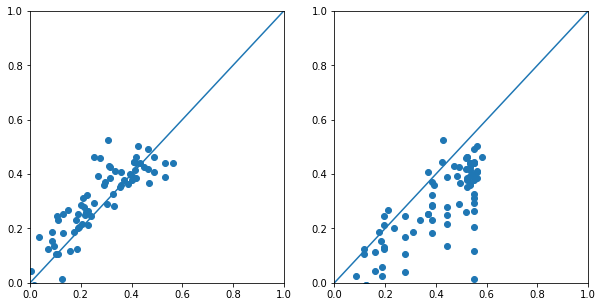

In [6]:
#nEpochs = 100

figSize(5, 10)

plt.subplot(1, 2, 1)
plt.scatter(scores_dict['meanrecal'], scores_dict['HMM'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1])

plt.subplot(1, 2, 2)
plt.scatter(scores_dict['linear'], scores_dict['HMM'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1])

plt.show()

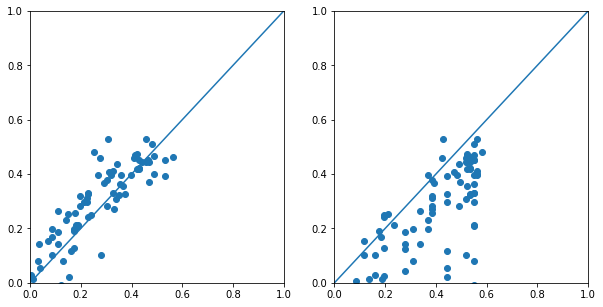

In [7]:
# nEpochs = 50

figSize(5, 10)

plt.subplot(1, 2, 1)
plt.scatter(scores_dict['meanrecal'], scores_dict['HMM'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1])

plt.subplot(1, 2, 2)
plt.scatter(scores_dict['linear'], scores_dict['HMM'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1])

plt.show()

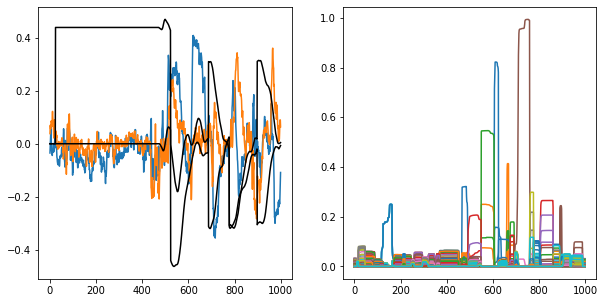

In [8]:
figSize(5, 10)

window = np.arange(0, 1000)

plt.subplot(1, 2, 1)
plt.plot(preds[0].squeeze()[window, :])
plt.plot(y_train[0][window, :], c = 'k')

plt.subplot(1, 2, 2)
plt.plot(pTargs[:, window].T)
plt.show()

In [45]:
preds[0].shape

(37452, 1, 2)

In [15]:
date

't5.2016.09.26'

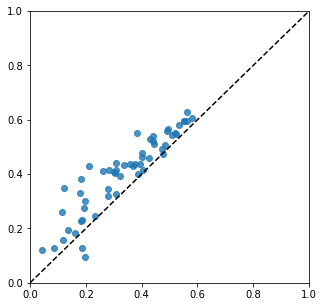

In [20]:
figSize(5, 5)

plt.scatter(scores_dict['linear'], scores_dict['RNN'], alpha = 0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'k')

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'

#plt.savefig(fig_path + 'RNN/rnn_vs_meanrecalLinear.pdf')
plt.show()

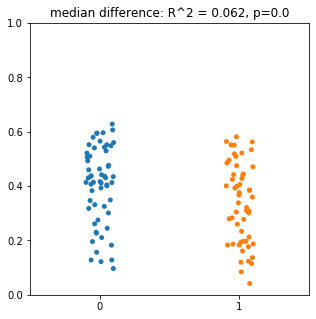

In [35]:
import seaborn as sns 

med_diff = np.median(scores_dict['RNN'] - scores_dict['linear']) 
pval     = scipy.stats.wilcoxon(scores_dict['RNN'], scores_dict['linear'])[1]

sns.stripplot(data = [x for x in scores_dict.values()])
plt.ylim([0, 1])
plt.title('median difference: R^2 = ' + str(np.round(med_diff, 3)) + ', p=' + str(np.round(pval, 3)))

plt.savefig(fig_path + 'RNN/rnn_vs_meanrecalLinear_wilcoxon.eps')
plt.show()

In [17]:
import sys, glob

data_dir = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'


In [19]:
len(glob.glob(data_dir + 'RNNs/*'))

61